# Elliptical Slice Sampling
The purpose of this notebook is to check if the `elliptic.py` file implementing Elliptical Slice Sampling works as expected, whilst demonstrating how it can be used to sample from the latent variable posterior $p(\mathbf{f} | \mathbf{y}, \boldsymbol{\theta})$.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from gproc.elliptic_cpp import ess_samples_probit_cpp
from gproc.generative import sample_at_x
from gproc.kernels import squared_exponential
from gproc.kernels import rational_quadratic
from gproc.kernels import periodic

## Data Generation

In [2]:
N = 500 # Data size
D = 1 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
#y, prob_y, f = sample_at_x(x, kernel_fcn=periodic, kernel_params = {'lengthscale': 1, 'variance': 1.4, 'period':2})
y, prob_y, f = sample_at_x(x, kernel_fcn=squared_exponential, kernel_params = {'lengthscale': 0.1, 'variance': 1.4})
y=y.astype("float64")

## Generate Latent Posterior Samples

In [3]:
model_lengthscale=0.1
model_variance=1.4
K = squared_exponential(x, x, lengthscale=model_lengthscale, variance=model_variance)
#K = rational_quadratic(x, x, lengthscale=0.1, variance=1.4, weighting=1)
#K = periodic(x, x, lengthscale=1, variance=1.4, period=2)
K_chol = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
samples = ess_samples_probit_cpp(K_chol, y, 2500, 500, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:55<00:00, 54.41it/s]


## Mean of Samples Against True Function and Laplace

### ESS Samples Mean

In [4]:
ess_mean = np.mean(samples, axis=0)

In [5]:
samples

array([[2.55725072, 1.36449956, 2.53200494, ..., 1.62322638, 1.42817159,
        1.20968732],
       [2.45099915, 1.47231757, 2.42670428, ..., 1.69572136, 1.52670687,
        1.36364302],
       [2.71209111, 1.33756611, 2.6913502 , ..., 1.6003084 , 1.40207726,
        1.19035625],
       ...,
       [2.11247703, 1.99004399, 2.10771836, ..., 2.06204797, 2.00196854,
        1.96816839],
       [2.10561686, 1.93752142, 2.10094451, ..., 2.01307965, 1.95005846,
        1.92485641],
       [2.0886567 , 1.96675623, 2.08444968, ..., 2.05036226, 1.98295286,
        1.93814672]])

### Laplace Approximation

In [6]:
from gproc.laplace import laplace_approximation_probit, chol_inverse

laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, chol_inverse(K))

In [7]:
laplace_samples = np.random.multivariate_normal(laplace_mean, laplace_cov, 2500)

## Plot Means

In [8]:
ess_mean.shape

(500,)

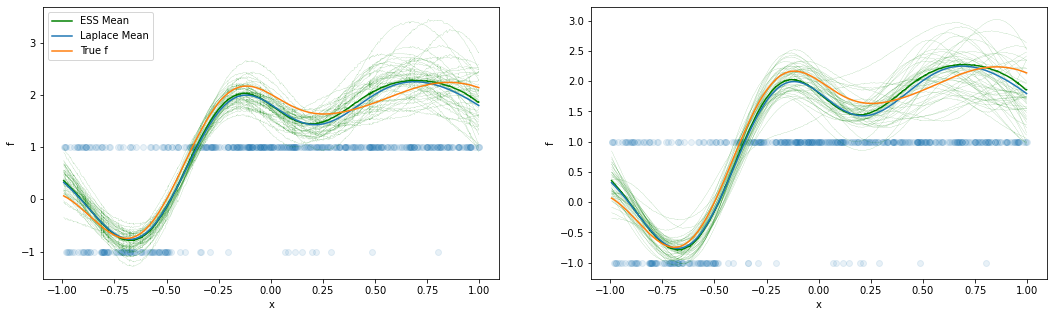

In [9]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [1,1]})

axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')

for i in range(0, samples.shape[0], 50):
    axarr[0].plot(x[sort_ix], samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[0].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')

axarr[0].legend()

axarr[1].scatter(x, y, alpha=0.1)
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('f')

for i in range(0, laplace_samples.shape[0], 50):
    axarr[1].plot(x[sort_ix], laplace_samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[1].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[1].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[1].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].legend()

(array([  6.,   7.,   2.,  17.,  14.,  42.,  57.,  66.,  73.,  55.,  70.,
         87.,  80.,  86.,  81., 107., 113., 116., 121., 133., 135., 132.,
        151.,  97.,  85.,  56.,  53.,  36.,  50.,  34.,  41.,  50.,  29.,
         36.,  32.,  18.,  22.,  13.,  14.,   9.,  16.,  15.,  15.,  11.,
          3.,   6.,   1.,   0.,   2.,   5.]),
 array([1.44655776, 1.48619094, 1.52582412, 1.5654573 , 1.60509048,
        1.64472366, 1.68435684, 1.72399002, 1.7636232 , 1.80325638,
        1.84288956, 1.88252274, 1.92215592, 1.9617891 , 2.00142228,
        2.04105546, 2.08068864, 2.12032182, 2.159955  , 2.19958818,
        2.23922136, 2.27885454, 2.31848772, 2.3581209 , 2.39775408,
        2.43738726, 2.47702043, 2.51665361, 2.55628679, 2.59591997,
        2.63555315, 2.67518633, 2.71481951, 2.75445269, 2.79408587,
        2.83371905, 2.87335223, 2.91298541, 2.95261859, 2.99225177,
        3.03188495, 3.07151813, 3.11115131, 3.15078449, 3.19041767,
        3.23005085, 3.26968403, 3.30931721, 3.

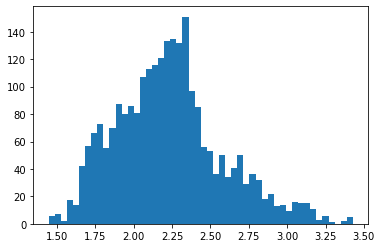

In [10]:
plt.hist(samples[:,0], bins=50)